In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix, zeros
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import Modem, QAMModem
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from utils.models import mzm, linFiberCh

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

In [4]:
import sympy as sp
from IPython.display import Math, display

# função para print de expressões simbólicas
def symdisp(expr, var, unit=' '):
    '''
    Latex style display of sympy expressions
    
    :param expr: expression in latex [string]
    :param var: sympy variable, function, expression.
    :param unit: string indicating unit of var [string]
    '''
    display(Math(expr+sp.latex(var)+'\;'+unit))

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Por-que-comunicações-ópticas-coerentes?" data-toc-modified-id="Por-que-comunicações-ópticas-coerentes?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Por que comunicações ópticas coerentes?</a></span></li><li><span><a href="#Detecção-coerente-de-sinais-ópticos" data-toc-modified-id="Detecção-coerente-de-sinais-ópticos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Detecção coerente de sinais ópticos</a></span></li><li><span><a href="#Batimento-do-sinal-recebido-com-o-oscilador-local" data-toc-modified-id="Batimento-do-sinal-recebido-com-o-oscilador-local-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Batimento do sinal recebido com o oscilador local</a></span></li><li><span><a href="#Híbrida-$2\times-4$-90°" data-toc-modified-id="Híbrida-$2\times-4$-90°-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Híbrida $2\times 4$ 90°</a></span><ul class="toc-item"><li><span><a href="#Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida" data-toc-modified-id="Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exemplo de um circuito fotônico que implementa uma híbrida</a></span></li><li><span><a href="#Matriz-de-transferência-entrada-saída" data-toc-modified-id="Matriz-de-transferência-entrada-saída-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Matriz de transferência entrada-saída</a></span></li><li><span><a href="#Derivação-das-expressões-para-o-front-end-coerente" data-toc-modified-id="Derivação-das-expressões-para-o-front-end-coerente-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Derivação das expressões para o front-end coerente</a></span></li><li><span><a href="#Tipos-de-detecção-óptica-coerente" data-toc-modified-id="Tipos-de-detecção-óptica-coerente-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Tipos de detecção óptica coerente</a></span></li></ul></li><li><span><a href="#Exemplo:-detecção-coerente-de-um-laser-não-modulado" data-toc-modified-id="Exemplo:-detecção-coerente-de-um-laser-não-modulado-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exemplo: detecção coerente de um laser não-modulado</a></span></li><li><span><a href="#Exemplo:-simulação-10G-OOK-vs-10G-BPSK" data-toc-modified-id="Exemplo:-simulação-10G-OOK-vs-10G-BPSK-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exemplo: simulação 10G OOK vs 10G BPSK</a></span></li><li><span><a href="#Exemplo:-simulação-com-formatos-QPSK,-QAM" data-toc-modified-id="Exemplo:-simulação-com-formatos-QPSK,-QAM-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exemplo: simulação com formatos QPSK, QAM</a></span></li></ul></div>

# Comunicações Ópticas Coerentes

## Por que comunicações ópticas coerentes?

* Receptores com melhor sensitividade.

* Laser sintonizáveis podem ser utilizados para detecção coerente em sistemas WDM.

* Possibilidade de compensação via DSP de efeitos distorcivos do canal óptico (dispersão cromática, PMD, etc).

* Uso de técnicas avançadas de modulação e codificação.

* Maior eficiência no uso do espectro disponível na fibra.

## Detecção coerente de sinais ópticos


<img src="./figuras/Rx_OOK.png" width="400">

<img src="./figuras/hibrida_4x90.png" width="750">

In [5]:
t, A, ω_c, ω_lo, ϕ, ϕ_lo, Δω, Δϕ = sp.symbols('t, A, ω_c, ω_{LO}, ϕ, ϕ_{LO}, Δω, Δϕ', real=True)
P_s, P_lo, R = sp.symbols('P_s, P_{LO}, R_d', real=True, positive=True)

π = sp.pi
j = sp.I

**Campo elétrico da portadora óptica modulada $E_s(t)$**

In [6]:
E_s = sp.sqrt(P_s)*A*sp.exp(j*(ω_c*t + ϕ))

symdisp('E_s(t) =', E_s)

<IPython.core.display.Math object>

**Campo elétrico do laser oscilador local $E_{LO}(t)$**

In [7]:
E_lo = sp.sqrt(P_lo)*sp.exp(j*(ω_lo*t + ϕ_lo))

symdisp('E_{LO}(t) =', E_lo)

<IPython.core.display.Math object>

## Batimento do sinal recebido com o oscilador local

$$
\begin{aligned}
I_1(t) &= R_d\left|E_s(t) + jE_{LO}(t) \right|^2 \nonumber\\
       &= R_d\left[E_s(t) + jE_{LO}(t) \right]\left[E_s^*(t) - jE_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[E_s(t)E_s^*(t) + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) -j^2E_{LO}(t)E_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[A^2P_s + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) + P_{LO}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d\left[ jE_{LO}(t)E_s^*(t) +(jE_{LO}(t)E_s^*(t))^* \right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d 2\operatorname{Re}\left[jE_{LO}(t)E_s^*(t)\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_d\operatorname{Re}\left[j\sqrt{P_{LO}}e^{j(ω_{LO}t + ϕ_{LO})}A\sqrt{P_{s}}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[je^{j(ω_{LO}t + ϕ_{LO})}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[e^{j(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\cos(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] - 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_{LO}t -ω_ct + ϕ_{LO} - ϕ) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_ct - ω_{LO}t + ϕ - ϕ_{LO}) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(\Delta ωt + \Delta \phi) \nonumber\\
\end{aligned}
$$

em que $\Delta \omega_c = \omega - \omega_{LO}$ e $\Delta \phi = \phi - \phi_{LO}$.

**Fotocorrente $i_1(t)\propto |E_s + jE_{LO}|^2$**

In [8]:
i_1 = R*(E_s + j*E_lo)*sp.conjugate(E_s + j*E_lo)

i_1 = sp.re(i_1).simplify().expand()

symdisp('i_1(t) =', i_1)

<IPython.core.display.Math object>

**Fotocorrente $i_2(t) \propto |E_s - jE_{LO}|^2$**

In [9]:
i_2 = R*(E_s -j*E_lo)*sp.conjugate(E_s -j*E_lo)

i_2 = sp.re(i_2).simplify().expand()

symdisp('i_2(t) =', i_2)

<IPython.core.display.Math object>

**Corrente $s_Q(t) = i_1(t)-i_2(t)$**

In [10]:
s_Q = i_1 - i_2 # saída do fotodetector balanceado

s_Q = s_Q.simplify()

symdisp('s_Q(t) =', s_Q)

<IPython.core.display.Math object>

**Fotocorrente $i_3(t) \propto |E_s + E_{LO}|^2$**

In [11]:
i_3 = R*(E_s + E_lo)*sp.conjugate(E_s + E_lo)

i_3 = sp.re(i_3).simplify().expand()

symdisp('i_3(t) =', i_3)

<IPython.core.display.Math object>

**Fotocorrente $i_4(t) \propto |E_s - E_{LO}|^2$**

In [12]:
i_4 = R*(E_s - E_lo)*sp.conjugate(E_s - E_lo)

i_4 = sp.re(i_4).simplify().expand()

symdisp('i_4(t) =', i_4)

<IPython.core.display.Math object>

**Corrente $s_I(t) = i_3(t)-i_4(t)$**

In [13]:
s_I = i_3 - i_4 # saída do fotodetector balanceado

s_I = s_I.simplify()

symdisp('s_I(t) =', s_I)

<IPython.core.display.Math object>

**Sinal complexo detectado $s(t) = s_I(t) + js_Q(t)$**

In [14]:
s = s_I + j*s_Q

s = s.simplify()

symdisp('s(t) =', s)

<IPython.core.display.Math object>

## Híbrida $2\times 4$ 90°

### Exemplo de um circuito fotônico que implementa uma híbrida

<img src="./figuras/hibrida_PIC.png" width="400">

### Matriz de transferência entrada-saída

$$M=\left[\begin{array}{cccc}\frac{\sqrt{2}}{2} & \frac{\sqrt{2} j}{2} & 0 & 0 \\ \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2} & 0 & 0 \\ 0 & 0 & \frac{\sqrt{2}}{2} & \frac{\sqrt{2 j}}{2} \\ 0 & 0 & \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2}\end{array}\right]$$

$$
U=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & i
\end{array}\right]
$$

$$ T = MUM $$

### Derivação das expressões para o front-end coerente

**Matriz de transferência do acoplador 3dB**

In [15]:
C_3dB  = 1/sp.sqrt(2)*Matrix([[1, j],[j, 1]])

symdisp('C_{3dB} = ', C_3dB)

<IPython.core.display.Math object>

**Matriz de transferência da híbrida $2\times4$ 90°**

In [16]:
M = Matrix([[C_3dB, zeros(2)], [zeros(2), C_3dB]])
U = Matrix([[1, 0, 0, 0],[0, 0, 1, 0],[0, 1, 0, 0],[0, 0, 0, j]])

symdisp('M = ', M)
symdisp('U = ', U)
symdisp('T = MUM = ', M*U*M)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Derivação das expressões do *front-end* coerente com o Sympy**

In [17]:
# define funções do sympy para auxílio na derivação das expressões

# híbrida
def hybrid_2x4_90(E1, E2):
    
    M = Matrix([[C_3dB, zeros(2)], 
                [zeros(2), C_3dB]])
    
    U = Matrix([[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, j]])
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vetor 4x1
    
    Eo = M*U*M*Ei 
    
    return Eo    

# fotodetector balanceado
def bpd(E1, E2, R=1):
    
    i1 = E1*sp.conjugate(E1) # |E1|^2
    i2 = E2*sp.conjugate(E2) # |E2|^2
    i = i1 - i2
    
    return R*sp.re(i).simplify().expand()

In [18]:
Eo = hybrid_2x4_90(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Matrix([[E_s],[0],[0],[E_lo]]))

Entrada óptica da híbrida:


<IPython.core.display.Math object>

In [19]:
print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)

Saída óptica da híbrida:


<IPython.core.display.Math object>

**Fotodetecção balanceada**

In [20]:
s_I = bpd(Eo[1], Eo[0], R) # fotodetecão balanceada de Eo[1] e Eo[0]
s_Q = bpd(Eo[2], Eo[3], R) # fotodetecão balanceada de Eo[2] e Eo[3]

symdisp('s_I = ', s_I)
symdisp('s_Q = ', s_Q)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Campo elétrico recuperado**

In [21]:
s  = s_I + j*s_Q
s  = s.simplify()

symdisp('s = ', s)

<IPython.core.display.Math object>

In [22]:
s = (s.subs({ω_lo:ω_c + Δω, ϕ:ϕ_lo + Δϕ})).simplify()

symdisp('s = ', s)

<IPython.core.display.Math object>

### Tipos de detecção óptica coerente

* **Detecção homódina (*homodyne detection*)**($\Delta\omega = 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são idênticas.

* **Detecção heteródina (*heterodyne detection*)**($\Delta\omega \neq 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são diferentes.

* **Detecção intradina (*intradyne detection*)**($\Delta\omega \approx 0$): a frequência do laser do transmissor e do laser oscilador local são "ligeiramente" diferentes.

In [23]:
# assumindo que portadora e oscilador local estão sincronizados em fase e frequência
s = s.subs({Δω:0})/(sp.sqrt(P_s)*sp.sqrt(P_lo)*R)

symdisp('s = ', s)

<IPython.core.display.Math object>

**Funções para modelagem de um receptor coerente utilizando o numpy**

In [2]:
def balancedPD(E1, E2, R):
    '''
    Balanced photodetector (BPD)
    
    '''
    i1 = R*E1*np.conj(E1)
    i2 = R*E2*np.conj(E2)
    
    return i1-i2

def hybrid_2x4_90deg(E1, E2):
    '''
    Optical 2 x 4 90° hybrid
    
    '''
    # Hybrid transfer matrix    
    T = np.array([[ 1/2,  1j/2,  1j/2, -1/2],
                  [ 1j/2, -1/2,  1/2,  1j/2],
                  [ 1j/2,  1/2, -1j/2, -1/2],
                  [-1/2,  1j/2, -1/2,  1j/2]])
    
    Ei = np.array([E1, np.zeros((E1.size,)), 
                   np.zeros((E1.size,)), E2])    
    
    Eo = T@Ei
    
    return Eo
    
def coherentReceiver(Es, Elo, Rd=1):
    '''
    Single polarization coherent optical front-end
    
    '''
    # Hybrid 2 x 4 90° 
    Eo = hybrid_2x4_90deg(Es, Elo)
        
    # balanced photodetection
    sI = balancedPD(Eo[1,:], Eo[0,:], Rd)
    sQ = balancedPD(Eo[2,:], Eo[3,:], Rd)
    
    return sI + 1j*sQ

In [3]:
def phaseNoise(lw, Nsamples, Ts):
    
    σ2 = 2*np.pi*lw*Ts    
    phi = np.zeros(Nsamples)
    
    for ind in range(0, Nsamples-1):
        phi[ind+1] = phi[ind] + normal(0, np.sqrt(σ2))
        
    return phi

## Exemplo: detecção coerente de um laser não-modulado

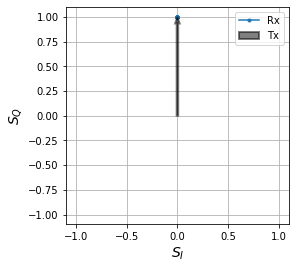

In [26]:
# parâmetros da simulação
Fa     = 128e9    # Frequência de amostragem do sinal
Ta     = 1/Fa     # Período de amostragem

Nsamples = 5000

#Pi_dBm = 10  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

#
lw = 0*100e3
pn_sig = phaseNoise(lw, Nsamples, Ta)
pn_lo  = phaseNoise(lw, Nsamples, Ta)

# parâmetros do sinal
Pin   = 1     # potência do laser
f_sig = 2e9   # frequência do sinal
ϕs    = π/2   # fase do laser

# parâmetros do oscilador local
Plo  = 1    # potência do oscilador local na entrada do receptor
f_lo = 2e9  # frequência do oscilador local
ϕ_lo = 0    # fase do oscilador local

############# Simulação #############

# oscilador local
t     = np.arange(0, Nsamples)*Ta
sig   = np.sqrt(Pin)*np.exp(1j*(2*π*f_sig*t + ϕs   + pn_sig))*np.ones(t.size)
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*f_lo*t + ϕ_lo + pn_lo))

# receptor coerente
sigRx = coherentReceiver(sig, sigLO)

plt.figure(figsize=(4,4))
plt.plot(sigRx.real,sigRx.imag,'o-', markersize=3, label='Rx')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.grid()

plt.arrow(0, 0, sig[0].real,sig[0].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'black', 
                                         facecolor = 'black', lw = 2, zorder = 5, label='Tx')
plt.legend(loc='upper right');

## Exemplo: simulação 10G OOK vs 10G BPSK

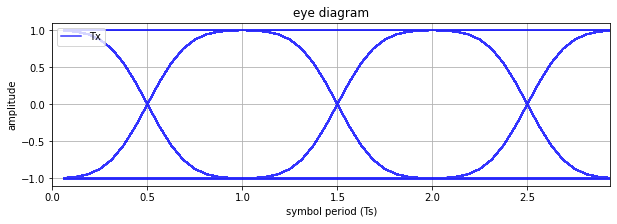

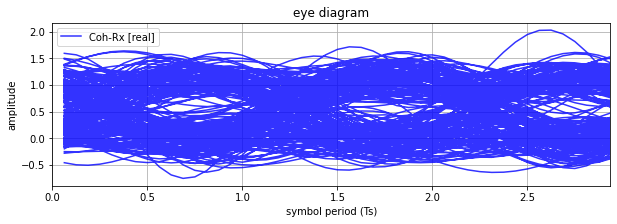

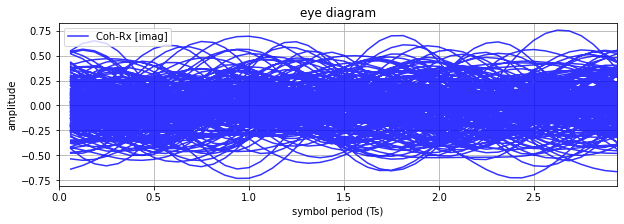

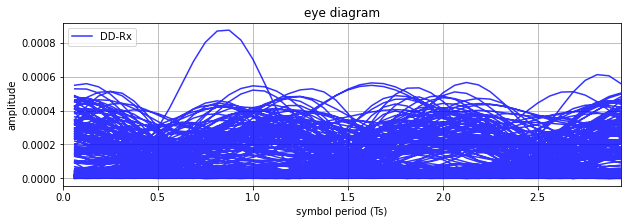

P_sig[opt] = -9.56 dBm
P_ase[opt] = -16.97 dBm
OSNR[est,Bsig] = 7.37 dB 

SNR[est] = 8.35 dB 

Total de erros contados = 111  
BER = 5.84e-03  


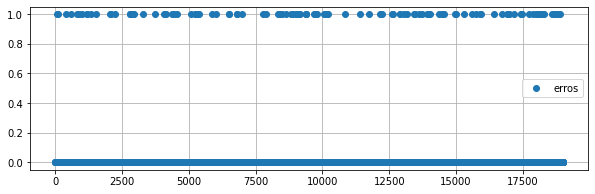

In [92]:
modulation = 'OOK' # 'OOK', 'BPSK'

# parâmetros da simulação
SpS    = 16            # número de amostras por símbolo
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

π = np.pi

# parâmetros do MZM
Vπ = 2

if modulation == 'OOK':
    Vb  = -Vπ/2
    Amp = 1
    Pi_dBm = -10+3.5  # potência de sinal óptico na entrada do modulador em dBm
elif modulation == 'BPSK':
    Vb = -Vπ
    Amp = 2
    Pi_dBm = -10  # potência de sinal óptico na entrada do modulador em dBm
    
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do receptor
B   = 10e9     # banda do receptor em Hz
Plo_dBm  = 10   # potência do oscilador local
Δf_lo = 0       # desvio de frequência do oscilador local
ϕ_lo  = 0       # fase do oscilador local

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=20000)    
n        = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = mzm(Ai, Vπ, Amp*sigTx, Vb)

# adiciona ruído ASE ao sinal óptico
σASE  = 1e-5
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t     = np.arange(0, sigTxo.size)*Ta
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receptor coerente
sigRx = coherentReceiver(sigTxo, sigLO)
sigRx = sigRx/np.std(sigRx)

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')
sigRx = firFilter(h, sigRx)

# calculando a OSNR na simulação
sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

OSNR = signal_power(sigTxo_Rx)/signal_power(ruido_Rx)

Nsamples = 10000

sigEye = sigRx.copy()
eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
eyediagram(sigEye[int(h.size/SpS)::], Nsamples, SpS, plotlabel = 'Coh-Rx')
eyediagram(np.abs(sigTxo_DDRx)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]
sigRx = sigRx/np.sqrt(signal_power(sigRx))

if modulation == 'OOK':
    symbTx = (symbTx+1)/np.sqrt(signal_power(symbTx+1))
    
# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[sigRx> symbTx.mean()] = 1
bitsRx[sigRx<= symbTx.mean()] = 0

discard = 500
ind = np.arange(discard, sigRx.size-discard)

# estima SNR do sinal recebido: SNR = Es/σ^2
SNR = 1/signal_power(sigRx[ind]-symbTx[ind])

err = np.logical_xor(bitsRx[ind], 
                     bitsTx[ind])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est,Bsig] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

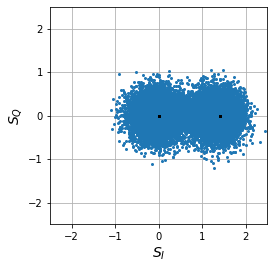

In [86]:
plt.figure(figsize=(4,4))
plt.axis('square')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

In [4]:
def iqm(Ai, sig, Vπ, VbI, VbQ):

    sigOut = mzm(Ai/np.sqrt(2), Vπ, sig.real, VbI) + 1j*mzm(Ai/np.sqrt(2), Vπ, sig.imag, VbQ)
    
    return sigOut

## Exemplo: simulação com formatos QPSK, QAM

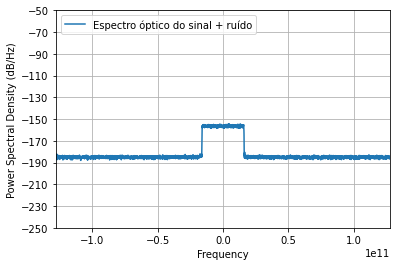

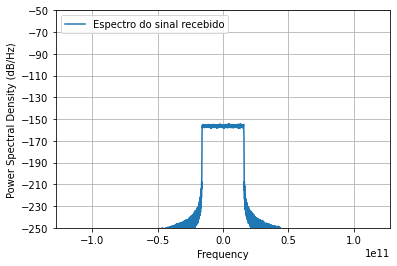

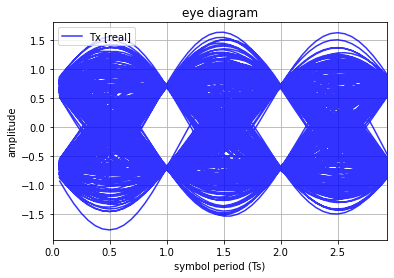

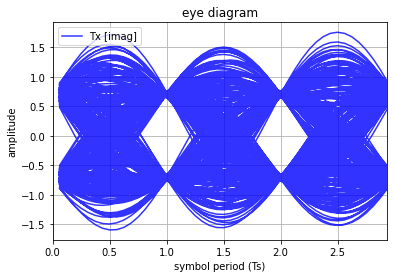

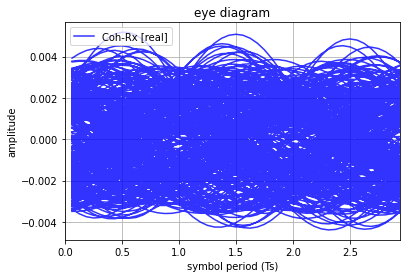

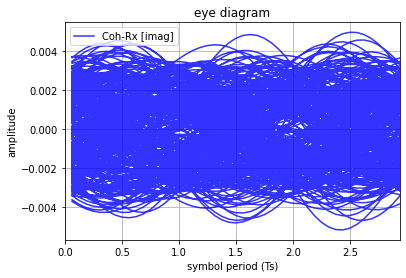

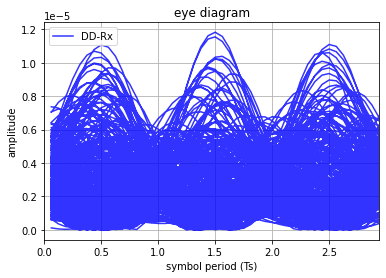

P_sig[opt] = -21.34 dBm
P_ase[opt] = -46.98 dBm
OSNR[est] = 28.67 dB 

SNR[est] = 9.89 dB 

Total de erros contados = 0  
BER = 0.00e+00  


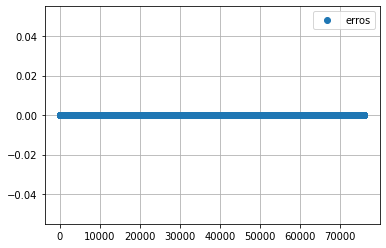

In [12]:
# parâmetros da simulação
M      = 4
SpS    = 16            # número de amostras por símbolo
Rs     = 32e9          # Taxa de símbolos 
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = -10#+2.45  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

# parâmetros do IQM
Vπ = 2
Vb = -Vπ
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do canal óptico
Ltotal = 10   # km
alpha = 0.2   # dB/km
D = 16        # ps/nm/km
Fc = 193.1e12 # Hz

# parâmetros do receptor
B  = 32e9     # banda do receptor em Hz

Plo_dBm  = 10    # potência do oscilador local
Δf_lo    = 0     # desvio de frequência do oscilador local
ϕ_lo     = 0     # fase do oscilador local
lw       = 0*10e3

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

############# Simulação #############

### Transmissor

# generate random bits
bitsTx   = np.random.randint(2, size=80000)    

# map bits to constellation symbols
mod = QAMModem(m=M)
symbTx = mod.modulate(bitsTx)
Es = mod.Es;

# normalize symbols energy to 1
symbTx = symbTx/np.sqrt(Es)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
#pulse = pulseShape('nrz', SpS)
pulse = pulseShape('rrc', SpS, N=2048, alpha=0.01, Ts=Ts)
pulse = pulse/np.max(np.abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)
    
# adiciona ruído ASE ao sinal óptico
σASE  = 1e-8
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

# calculando a OSNR na simulação
OSNR = signal_power(sigTxo_)/(signal_power(ruido)*(B/Fa))

# plota psd
plt.figure();
plt.ylim(-250,-50);
plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico do sinal + ruído')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);

### Canal óptico linear

sigTxo = linFiberCh(sigTxo, Ltotal, alpha, D, Fc, Fa)
#sigTxo = linFiberCh(sigTxo, Ltotal, -alpha, -D, Fc, Fa)

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t      = np.arange(0, sigTxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigTxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor coerente
sigRx = coherentReceiver(sigTxo, sigLO)
#sigRx = sigRx/np.sqrt(signal_power(sigRx))

# filtragem Rx
N = 4001
h = lowPassFIR(B, Fa, N, typeF='rect')

sigRx = firFilter(pulse, sigRx)

# plota psd
plt.figure();
plt.ylim(-250,-50);
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);

# calculando a OSNR na simulação
#sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

Nsamples = 16000
sigEye = sigRx.copy()

#visualiza diagramas de olho
eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
eyediagram(sigEye, Nsamples, SpS, plotlabel = 'Coh-Rx')
eyediagram(np.abs(sigTxo_DDRx)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constelação recebida
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# compensa (possível) rotação de fase adicionada pelo canal
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# estima SNR da constelação recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Aplica a regra de decisão brusca        
bitsRx = mod.demodulate(np.sqrt(Es)*sigRx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

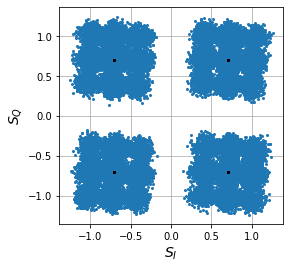

In [13]:
plt.figure(figsize=(4,4))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

In [97]:
freqSpac = 37.5e9
Nchannels = 
freqGrid = np.arange(-3,4,1)*freqSpac/2
freqGrid

array([-5.625e+10, -3.750e+10, -1.875e+10,  0.000e+00,  1.875e+10,
        3.750e+10,  5.625e+10])

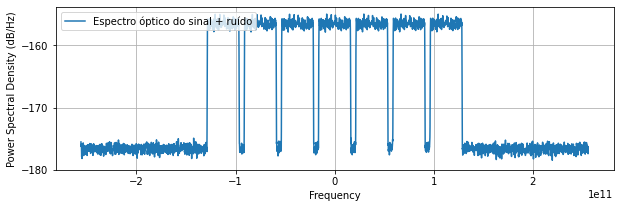

In [98]:
sig_WDM = np.zeros(sigTxo.size)

t = np.arange(0, sigTxo.size)

for f in freqGrid:
    sig_WDM = sig_WDM + sigTxo*np.exp(1j*2*π*(f/(Fa/2))*t)

# plota psd
plt.figure()
plt.psd(sig_WDM, Fs=Fa, NFFT = 4*1024, sides='twosided', label = 'Espectro óptico do sinal + ruído')
plt.legend(loc='upper left');